In [42]:
from dace_query.sun import Sun
import matplotlib.pyplot as plt
from astropy.io import fits
import os
import numpy as np
import jdcal as j 
from astropy.time import Time
from pathlib import Path

import pandas as pd


In [43]:
###Load the simulation data

#Path
path = '/home/sophie-stucki/sunsim//'
#Path of the classification maps
path_maps = '/home/sophie-stucki/sunsim/'
#Folder name
folder = 'maps_nonactive_2020_01-03'

rv_simu_mps = np.loadtxt(path + '{}/rv_test_mps.txt'.format(folder))
rv_simu_phoenix = np.loadtxt(path + '{}/rv_test_phoenix.txt'.format(folder))

bis_simu_mps = np.loadtxt(path + '{}/bis_test_mps.txt'.format(folder))
bis_simu_phoenix = np.loadtxt(path + '{}/bis_test_phoenix.txt'.format(folder))

fwhm_simu_mps = np.loadtxt(path + '{}/fwhm_test_mps.txt'.format(folder))
fwhm_simu_phoenix = np.loadtxt(path + '{}/fwhm_test_phoenix.txt'.format(folder))

cont_simu_mps = np.loadtxt(path + '{}/cont_test_mps.txt'.format(folder))
cont_simu_phoenix = np.loadtxt(path + '{}/cont_test_phoenix.txt'.format(folder))

days_simu = np.loadtxt(path_maps + '{}/days_list.txt'.format(folder))
# day_step = 7
# days_simu = range(95)

In [56]:
###Load the observation data

#Timeline of the simulations
start_time = j.gcal2jd(2020,1,1)[1] + 2400000.5
end_time = j.gcal2jd(2020,4,1)[1] + 2400000.5

#HARPS-N data
data = pd.read_csv('/home/sophie-stucki/starsim/starsim/SDO_input/2015-2025/2015-2025/harpn_sun_release_timeseries_2015-2025.csv')

#Sort the data
date = Time(np.array(data.bjd), format='jd', scale='tdb')
arg_sort = date.argsort()

rv = np.array(data.rv)[arg_sort] * 1e3
fwhm = np.array(data.fwhm)[arg_sort] * 1e3
bis = np.array(data.bis_span)[arg_sort]
fwhm = np.array(data.fwhm)[arg_sort]
contrast = np.array(data.contrast)[arg_sort]

date = date[arg_sort]
t = Time(data.bjd + 2400000, format='jd', scale='tdb')
# Convert to UTC calendar date
t_utc = t.utc


In [57]:
###Collect the observation data
date_harps = []
date_harps_fits = []

rv_harps = []
bis_harps = []
fwhm_harps = []
contrast_harps = []

for i in range(len(date)):
    if t_utc.jd[i] >= start_time and t_utc.jd[i] <= end_time:
        print('yes')

        date_harps.append(t_utc[i])
        date_harps_fits.append(t_utc[i].to_value('iso', 'date'))

        rv_harps.append(rv[i])
        bis_harps.append(bis[i])
        fwhm_harps.append(fwhm[i])
        contrast_harps.append(contrast[i])

In [53]:
#Compute the daily average
data_copy = pd.DataFrame({'date': date_harps_fits,
             'rv': rv_harps,
             'bis': bis_harps,
             'fwhm': fwhm_harps,
             'contrast': contrast_harps})

daily_avg = data_copy.groupby('date')[['rv', 'bis', 'fwhm', 'contrast']].mean().reset_index()

start_time = Time(start_time, format='jd')

days_harps = [(day - start_time).value for day in date_harps]
days_daily_avg = [(Time(str(day) + ' 00:00:00.000', format='iso') - start_time).value + 0.5 for day in daily_avg.date]

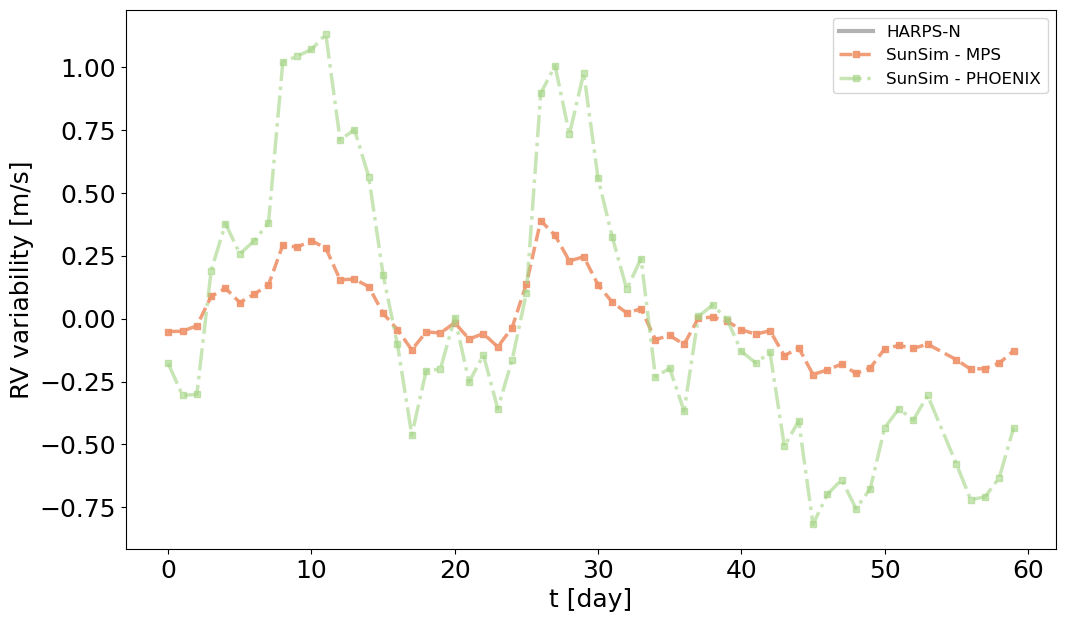

In [54]:
###Plot the comparison

plt.rcParams['font.size'] = 18
plt.rcParams['figure.figsize'] = (12,7)
plt.plot( days_daily_avg,  (daily_avg.rv - np.mean(daily_avg.rv)),'', label='HARPS-N', color="#000000", alpha =0.3, linewidth=3)
plt.plot(days_simu, (rv_simu_mps - np.mean(rv_simu_mps)) ,'s--', label = 'SunSim - MPS', color='#ef946c', alpha=0.9, markersize=5, linewidth=2.5)
plt.plot(days_simu, (rv_simu_phoenix - np.mean(rv_simu_phoenix)) ,'s-.', label = 'SunSim - PHOENIX', color="#a4d485", alpha=0.6, markersize=5, linewidth=2.5)

plt.xlabel('t [day]')
plt.ylabel('RV variability [m/s]')
plt.legend(fontsize=12)
plt.savefig(path + '{}/comparison_rv.png'.format(folder),  dpi=300, bbox_inches='tight')

IndexError: arrays used as indices must be of integer (or boolean) type

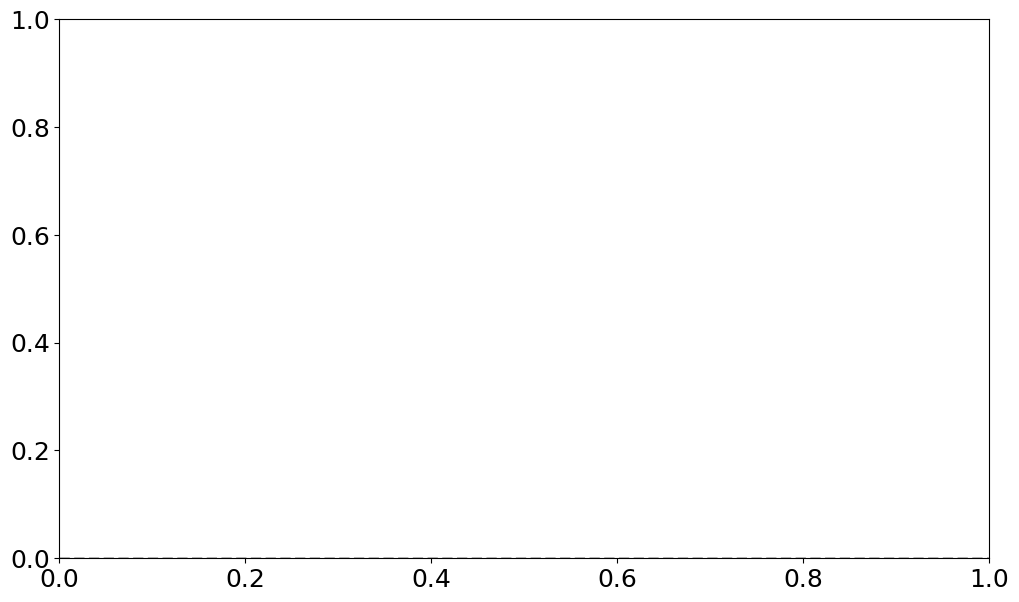

In [49]:
###Plot the residues

idx_h = []
idx = []

for k, d in enumerate(days_simu):
    for i, l in enumerate(days_daily_avg):
        if d == int(l - 0.5):
            idx_h.append(i)
            idx.append(k)

idx_h = np.squeeze(idx_h)
idx = np.squeeze(idx)

days_simu = np.array(days_simu)

plt.axhline(0, linestyle= '--', color="#000000", alpha =0.3, linewidth=2 )

plt.plot(days_simu[idx],  (daily_avg.rv[idx_h] - np.mean(daily_avg.rv[idx_h])) - (rv_simu_mps[idx] - np.mean(rv_simu_mps[idx])) ,'s--', label = 'SunSim - MPS', color='#ef946c', alpha=0.9, markersize=5, linewidth=2.5)
plt.plot(days_simu[idx], (daily_avg.rv[idx_h] - np.mean(daily_avg.rv[idx_h])) - (rv_simu_phoenix[idx] - np.mean(rv_simu_phoenix[idx])) ,'s-.', label = 'SunSim - PHOENIX', color="#a4d485", alpha=0.6, markersize=5, linewidth=2.5)
plt.xlabel('t [day]')
plt.ylabel('Residual [m/s]')
plt.legend(fontsize=10)
plt.text(45, -4, 'rms\nMPS-ATLAS: {:.2f} m/s\nPHOENIX: {:.2f} m/s'.format(np.sqrt(np.mean(((daily_avg.rv[idx_h] - np.mean(daily_avg.rv[idx_h])) - (rv_simu_mps[idx] - np.mean(rv_simu_mps[idx])))**2)),np.sqrt(np.mean(((daily_avg.rv[idx_h] - np.mean(daily_avg.rv[idx_h])) - (rv_simu_phoenix[idx] - np.mean(rv_simu_phoenix[idx])))**2))), alpha=0.4)
plt.savefig(path + '{}/res_comparison_rv.png'.format(folder),  dpi=300, bbox_inches='tight')
